# Initial Imports

In [1]:
import sqlite3
import pandas as pd

# Loading the SQL file

In [2]:
# Created connection.
database_path = r"database.sqlite"

conn = sqlite3.connect(database_path)

# Creating Object of all table into the SQL file

In [3]:
# Creating dataframes from the tbales

df_country = pd.read_sql_query("SELECT * FROM country", conn)
df_league = pd.read_sql_query("SELECT * FROM league", conn)
df_match = pd.read_sql_query("SELECT * FROM match", conn)
df_player = pd.read_sql_query("SELECT * FROM player", conn)
df_player_attributes = pd.read_sql_query("SELECT * FROM player_attributes", conn)
df_team = pd.read_sql_query("SELECT * FROM team", conn)
df_team_attributes = pd.read_sql_query("SELECT * FROM team_attributes", conn)
df_sqlite_sequence = pd.read_sql_query("SELECT * FROM sqlite_sequence", conn)


**Deleting duplicate values**

In [4]:
# Deleting Duplicate values from the table

df_country = df_country.drop_duplicates()
df_league = df_league.drop_duplicates()
df_match = df_match.drop_duplicates()
df_player = df_player.drop_duplicates()
df_player_attributes = df_player_attributes.drop_duplicates()
df_team = df_team.drop_duplicates()
df_team_attributes = df_team_attributes.drop_duplicates()
df_sqlite_sequence = df_sqlite_sequence.drop_duplicates()

# Marging all table into one table Section 

In [5]:
# Concate all the tables in one
# Note: removed and merged by analyzed the all table relationship by zeel. so, before making change make sure to communicate with zeel

# Merging Country Table and League Table

In [6]:
# merging country table
df_merged_all_table = pd.merge(left=df_league, right=df_country, how='outer', left_on='country_id', right_on='id')
df_merged_all_table = df_merged_all_table.drop(["id_x", "country_id"], axis=1)
df_merged_all_table.columns.values[0] = "league_name"
df_merged_all_table.columns.values[1] = "league_id"
df_merged_all_table.columns.values[2] = "country_name"

In [7]:
df_merged_all_table

league_name  league_id country_name
0     Belgium Jupiler League          1      Belgium
1     England Premier League       1729      England
2             France Ligue 1       4769       France
3      Germany 1. Bundesliga       7809      Germany
4              Italy Serie A      10257        Italy
5     Netherlands Eredivisie      13274  Netherlands
6         Poland Ekstraklasa      15722       Poland
7   Portugal Liga ZON Sagres      17642     Portugal
8    Scotland Premier League      19694     Scotland
9            Spain LIGA BBVA      21518        Spain
10  Switzerland Super League      24558  Switzerland

# Merging match Table and previous combined Table

In [8]:
# merging league table
df_merged_all_table = df_match.merge(df_merged_all_table, how='outer', left_on='league_id', right_on='league_id')
df_merged_all_table = df_merged_all_table.drop(["league_id", "country_id"], axis=1)
df_merged_all_table.columns.values[0] = "match_id" 
df_merged_all_table = df_merged_all_table.drop(["match_id"], axis=1)

# Merging team Table and team attribute Table

In [9]:
# merging team table and team_attribute table with latest records of team
df_team_attributes = pd.read_sql_query("select * from Team_Attributes group by team_api_id order by max(date) DESC", conn)

df_merged_team_table = pd.merge(left=df_team, right=df_team_attributes, how='outer', left_on=['team_api_id'], right_on=['team_api_id'])

In [10]:
df_merged_team_table = df_merged_team_table.drop(columns=["id_x", "team_fifa_api_id_x", "id_y", "team_fifa_api_id_y"])

* performing imputation

In [11]:
# removed class columns 
skip_count = 0
for i in df_merged_team_table.columns:
    if df_merged_team_table[i].dtype == "object":
        skip_count += 1
        if skip_count > 3:
            df_merged_team_table = df_merged_team_table.drop(columns=i)

In [12]:
# import the KNNimputer class
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

In [13]:
# getting team overall score based on mean
col_list = []
skip_count = 0
for i in df_merged_team_table.columns:
    skip_count += 1
    if skip_count > 4:
        col_list.append(i)

imputed_table = imputer.fit_transform(df_merged_team_table[col_list])

imputed_table = pd.DataFrame(imputed_table)
imputed_table = imputed_table.mean(axis = 1, skipna = False)

df_merged_team_table = df_merged_team_table.drop(columns=col_list)
df_merged_team_table = df_merged_team_table.drop(columns="date")
df_merged_team_table["team_overall_score"] = imputed_table

* imputation done and joined the imputed table with main team table

In [14]:
df_merged_team_table

team_api_id      team_long_name team_short_name  team_overall_score
0           9987            KRC Genk             GEN           51.777778
1           9993        Beerschot AC             BAC           49.000000
2          10000    SV Zulte-Waregem             ZUL           46.333333
3           9994    Sporting Lokeren             LOK           51.333333
4           9984   KSV Cercle Brugge             CEB           51.666667
..           ...                 ...             ...                 ...
294        10190       FC St. Gallen             GAL           43.222222
295        10191             FC Thun             THU           51.444444
296         9777         Servette FC             SER           50.333333
297         7730  FC Lausanne-Sports             LAU           50.000000
298         7896              Lugano             LUG           50.166908

[299 rows x 4 columns]

# Merging combined previous table with combined team table

* combine both the table and removed extra coulms 

In [15]:
# merging merged team table
df_merged_all_table = df_merged_all_table.merge(df_merged_team_table, how='outer', left_on=['home_team_api_id'], right_on=['team_api_id'])
df_merged_all_table.columns.values[2] = "date" 
df_merged_all_table = df_merged_all_table.merge(df_merged_team_table, how='outer', left_on=['away_team_api_id'], right_on=['team_api_id'])
df_merged_all_table.columns.values[2] = "date" 

for i in range(4):
    df_merged_all_table = df_merged_all_table.drop([df_merged_all_table.columns[-1]], axis=1)

for i in range(4):
    df_merged_all_table.columns.values[-1 - i] = df_merged_all_table.columns[-1 - i].split("_x")[0]

In [16]:
df_merged_all_table.columns

Index(['season', 'stage', 'date', 'match_api_id', 'home_team_api_id',
       'away_team_api_id', 'home_team_goal', 'away_team_goal',
       'home_player_X1', 'home_player_X2',
       ...
       'GBA', 'BSH', 'BSD', 'BSA', 'league_name', 'country_name',
       'team_api_id', 'team_long_name', 'team_short_name',
       'team_overall_score'],
      dtype='object', length=118)

# Merging player attribute table with player table

In [17]:
# merging team table and team_attribute table with latest records of team
df_player_attributes = pd.read_sql_query("select * from Player_Attributes group by Player_api_id order by max(date) DESC", conn)

# merging player_attribute table with player table
df_merged_player_table = pd.merge(left=df_player, right=df_player_attributes, how='outer', left_on=['player_api_id'], right_on=['player_api_id'])
df_merged_player_table = df_merged_player_table.drop(["id_x", "id_y", "player_fifa_api_id_y"], axis=1)
df_merged_player_table.columns.values[2] = "player_fifa_api_id" 
df_merged_player_table = df_merged_player_table.drop(columns="player_fifa_api_id") 

df_merged_player_table = df_merged_player_table.drop_duplicates() 

In [18]:
df_merged_player_table = df_merged_player_table.drop(columns=["date", "birthday"])

In [19]:
df_merged_player_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11060 entries, 0 to 11059
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_api_id        11060 non-null  int64  
 1   player_name          11060 non-null  object 
 2   height               11060 non-null  float64
 3   weight               11060 non-null  int64  
 4   overall_rating       11060 non-null  int64  
 5   potential            11060 non-null  int64  
 6   preferred_foot       11060 non-null  object 
 7   attacking_work_rate  10520 non-null  object 
 8   defensive_work_rate  11060 non-null  object 
 9   crossing             11060 non-null  int64  
 10  finishing            11060 non-null  int64  
 11  heading_accuracy     11060 non-null  int64  
 12  short_passing        11060 non-null  int64  
 13  volleys              10582 non-null  float64
 14  dribbling            11060 non-null  int64  
 15  curve                10582 non-null 

* To decide which column should we need to take and whoch columns need to impute

In [20]:
df_merged_player_table.isnull().sum()

player_api_id            0
player_name              0
height                   0
weight                   0
overall_rating           0
potential                0
preferred_foot           0
attacking_work_rate    540
defensive_work_rate      0
crossing                 0
finishing                0
heading_accuracy         0
short_passing            0
volleys                478
dribbling                0
curve                  478
free_kick_accuracy       0
long_passing             0
ball_control             0
acceleration             0
sprint_speed             0
agility                478
reactions                0
balance                478
shot_power               0
jumping                478
stamina                  0
strength                 0
long_shots               0
aggression               0
interceptions            0
positioning              0
vision                 478
penalties                0
marking                  0
standing_tackle          0
sliding_tackle         478
g

In [21]:
df_merged_player_table = df_merged_player_table.drop(columns=["preferred_foot", "attacking_work_rate", "defensive_work_rate"])

* implementing imputatuon to reduce the shape of the table

In [22]:
imputer = KNNImputer(n_neighbors=2)

In [23]:
# getting team overall score based on mean
col_list = []
skip_count = 0
for i in df_merged_player_table.columns:
    skip_count += 1
    if skip_count > 5:
        col_list.append(i)

imputed_table = imputer.fit_transform(df_merged_player_table[col_list])

imputed_table = pd.DataFrame(imputed_table)
imputed_table = imputed_table.mean(axis = 1, skipna = False)

df_merged_player_table = df_merged_player_table.drop(columns=col_list)
df_merged_player_table["player_overall_score"] = imputed_table

In [24]:
df_merged_player_table

player_api_id          player_name  height  weight  overall_rating  \
0             505942   Aaron Appindangoye  182.88     187              67   
1             155782      Aaron Cresswell  170.18     146              74   
2             162549          Aaron Doran  170.18     163              65   
3              30572        Aaron Galindo  182.88     198              69   
4              23780         Aaron Hughes  182.88     154              70   
...              ...                  ...     ...     ...             ...   
11055          26357       Zoumana Camara  182.88     168              73   
11056         111182         Zsolt Laczko  182.88     176              63   
11057          36491            Zsolt Low  180.34     154              68   
11058          35506  Zurab Khizanishvili  185.42     172              67   
11059          39902   Zvjezdan Misimovic  180.34     176              78   

       player_overall_score  
0                 49.852941  
1                 61.000000  
2                 53.794118  
3                 48.029412  
4                 46.264706  
...                     ...  
11055             50.647059  
11056             51.441176  
11057             55.000000  
11058             50.294118  
11059             57.647059  

[11060 rows x 6 columns]

* converting player's weight and height into player_body_rate for idead player body rate

In [25]:
def calculate_ideal_player_body_rate(weight, height):

    # Sample formula: Ideal Body Rate = Weight / Height^2 (need to analyse the effective formula)
    ideal_body_rate = weight / (height/100) ** 2
    return ideal_body_rate

In [26]:
df_merged_player_table['player_ideal_body_rate'] = df_merged_player_table.apply(lambda row: calculate_ideal_player_body_rate(row['weight'], row['height']), axis=1)

In [27]:
df_merged_player_table = df_merged_player_table.drop(columns=["height", "weight"])

In [28]:
df_merged_player_table

player_api_id          player_name  overall_rating  \
0             505942   Aaron Appindangoye              67   
1             155782      Aaron Cresswell              74   
2             162549          Aaron Doran              65   
3              30572        Aaron Galindo              69   
4              23780         Aaron Hughes              70   
...              ...                  ...             ...   
11055          26357       Zoumana Camara              73   
11056         111182         Zsolt Laczko              63   
11057          36491            Zsolt Low              68   
11058          35506  Zurab Khizanishvili              67   
11059          39902   Zvjezdan Misimovic              78   

       player_overall_score  player_ideal_body_rate  
0                 49.852941               55.912535  
1                 61.000000               50.412219  
2                 53.794118               56.282135  
3                 48.029412               59.201507  
4                 46.264706               46.045617  
...                     ...                     ...  
11055             50.647059               50.231582  
11056             51.441176               52.623562  
11057             55.000000               47.351811  
11058             50.294118               50.028248  
11059             57.647059               54.116355  

[11060 rows x 5 columns]

# Adding new feature Player overall rating into match table

In [29]:
df_merged_all_table.drop_duplicates(inplace=True)

In [30]:
# combining total goal of a respected team

home_total_goal = pd.read_sql_query("select home_team_api_id, sum(home_team_goal) as home_total_goal from match group by home_team_api_id", conn)
away_total_goal = pd.read_sql_query("select away_team_api_id, sum(away_team_goal) as away_total_goal from match group by away_team_api_id", conn)

In [31]:
# merging both the home and away total goal to the match table

df_merged_all_table = pd.merge(df_merged_all_table, home_total_goal, on='home_team_api_id')
df_merged_all_table = pd.merge(df_merged_all_table, away_total_goal, on='away_team_api_id')

In [32]:
df_merged_player_table.head()

player_api_id         player_name  overall_rating  player_overall_score  \
0         505942  Aaron Appindangoye              67             49.852941   
1         155782     Aaron Cresswell              74             61.000000   
2         162549         Aaron Doran              65             53.794118   
3          30572       Aaron Galindo              69             48.029412   
4          23780        Aaron Hughes              70             46.264706   

   player_ideal_body_rate  
0               55.912535  
1               50.412219  
2               56.282135  
3               59.201507  
4               46.045617

* This section was implimented before the df_merged_player_table now dont need this so i commented it

In [33]:
# getting overall rating of player

# player_overall_rating = pd.read_sql_query("select * from (select player_api_id , max(overall_rating) as overall_rating from Player_Attributes group by player_api_id) as p where p.overall_rating is not null", conn)


In [34]:
# player_overall_rating

* combining player overall rating value to match table with home and away player

In [35]:
# for i in range(1,12):
#     df_merged_all_table = df_merged_all_table.merge(player_overall_rating, how='left', left_on='home_player_' + str(i), right_on='player_api_id')
#     df_merged_all_table = df_merged_all_table.drop(['home_player_' + str(i), "player_api_id"], axis=1)
#     df_merged_all_table.columns.values[-1] = 'home_player_' + str(i) 

# for i in range(1,12):
#     df_merged_all_table = df_merged_all_table.merge(player_overall_rating, how='left', left_on='away_player_' + str(i), right_on='player_api_id')
#     df_merged_all_table = df_merged_all_table.drop(['away_player_' + str(i), "player_api_id"], axis=1)
#     df_merged_all_table.columns.values[-1] = 'away_player_' + str(i) 

# df_merged_all_table = df_merged_all_table.drop([], axis=1)

In [36]:
temp_list = "season stage date home_team_api_id away_team_api_id home_player_X1 home_player_X2 home_player_X3 home_player_X4 home_player_X5 home_player_X6 home_player_X7 home_player_X8 home_player_X9 home_player_X10 home_player_X11 away_player_X1 away_player_X2 away_player_X3 away_player_X4 away_player_X5 away_player_X6 away_player_X7 away_player_X8 away_player_X9 away_player_X10 away_player_X11 home_player_Y1 home_player_Y2 home_player_Y3 home_player_Y4 home_player_Y5 home_player_Y6 home_player_Y7 home_player_Y8 home_player_Y9 home_player_Y10 home_player_Y11 away_player_Y1 away_player_Y2 away_player_Y3 away_player_Y4 away_player_Y5 away_player_Y6 away_player_Y7 away_player_Y8 away_player_Y9 away_player_Y10 away_player_Y11".split(" ")

In [37]:
temp_list

['season',
 'stage',
 'date',
 'home_team_api_id',
 'away_team_api_id',
 'home_player_X1',
 'home_player_X2',
 'home_player_X3',
 'home_player_X4',
 'home_player_X5',
 'home_player_X6',
 'home_player_X7',
 'home_player_X8',
 'home_player_X9',
 'home_player_X10',
 'home_player_X11',
 'away_player_X1',
 'away_player_X2',
 'away_player_X3',
 'away_player_X4',
 'away_player_X5',
 'away_player_X6',
 'away_player_X7',
 'away_player_X8',
 'away_player_X9',
 'away_player_X10',
 'away_player_X11',
 'home_player_Y1',
 'home_player_Y2',
 'home_player_Y3',
 'home_player_Y4',
 'home_player_Y5',
 'home_player_Y6',
 'home_player_Y7',
 'home_player_Y8',
 'home_player_Y9',
 'home_player_Y10',
 'home_player_Y11',
 'away_player_Y1',
 'away_player_Y2',
 'away_player_Y3',
 'away_player_Y4',
 'away_player_Y5',
 'away_player_Y6',
 'away_player_Y7',
 'away_player_Y8',
 'away_player_Y9',
 'away_player_Y10',
 'away_player_Y11']

In [38]:
df_merged_all_table.columns

Index(['season', 'stage', 'date', 'match_api_id', 'home_team_api_id',
       'away_team_api_id', 'home_team_goal', 'away_team_goal',
       'home_player_X1', 'home_player_X2',
       ...
       'BSD', 'BSA', 'league_name', 'country_name', 'team_api_id',
       'team_long_name', 'team_short_name', 'team_overall_score',
       'home_total_goal', 'away_total_goal'],
      dtype='object', length=120)

In [39]:
df_merged_all_table = df_merged_all_table.drop(columns= temp_list)

In [40]:
df_merged_all_table.columns

Index(['match_api_id', 'home_team_goal', 'away_team_goal', 'home_player_1',
       'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5',
       'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9',
       'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2',
       'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6',
       'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10',
       'away_player_11', 'goal', 'shoton', 'shotoff', 'foulcommit', 'card',
       'cross', 'corner', 'possession', 'B365H', 'B365D', 'B365A', 'BWH',
       'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD',
       'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA',
       'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA', 'league_name', 'country_name',
       'team_api_id', 'team_long_name', 'team_short_name',
       'team_overall_score', 'home_total_goal', 'away_total_goal'],
      dtype='object')

# Merging player merged table with main merged table

In [41]:
for i in range(1,12):
    df_merged_all_table = df_merged_all_table.merge(df_merged_player_table, how='left', left_on=['home_player_' + str(i)], right_on=['player_api_id'])
    df_merged_all_table = df_merged_all_table.drop(['home_player_' + str(i), "player_api_id", "player_name"], axis=1)
    df_merged_all_table.columns.values[-1] = 'home_player_' + str(i) + "_ideal_body_rate"
    df_merged_all_table.columns.values[-2] = 'home_player_' + str(i) + "_overall_score"
    df_merged_all_table.columns.values[-3] = 'home_player_' + str(i) + "_overall_rating"

for i in range(1,12):
    df_merged_all_table = df_merged_all_table.merge(df_merged_player_table, how='left', left_on=['away_player_' + str(i)], right_on=['player_api_id'])
    df_merged_all_table = df_merged_all_table.drop(['away_player_' + str(i), "player_api_id", "player_name"], axis=1)
    df_merged_all_table.columns.values[-1] = 'away_player_' + str(i) + "_ideal_body_rate"
    df_merged_all_table.columns.values[-2] = 'away_player_' + str(i) + "_overall_score"
    df_merged_all_table.columns.values[-3] = 'away_player_' + str(i) + "_overall_rating"



In [42]:
df_merged_all_table.columns

Index(['match_api_id', 'home_team_goal', 'away_team_goal', 'goal', 'shoton',
       'shotoff', 'foulcommit', 'card', 'cross', 'corner',
       ...
       'away_player_8_ideal_body_rate', 'away_player_9_overall_rating',
       'away_player_9_overall_score', 'away_player_9_ideal_body_rate',
       'away_player_10_overall_rating', 'away_player_10_overall_score',
       'away_player_10_ideal_body_rate', 'away_player_11_overall_rating',
       'away_player_11_overall_score', 'away_player_11_ideal_body_rate'],
      dtype='object', length=115)

* performing imputation

* note:- need to take opinion of all group memeber on this imputation

In [43]:
# import the KNNimputer class
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

In [44]:
# getting player table based on mean
col_list = []
skip_count = 0
for i in df_merged_all_table.columns:
    skip_count += 1
    if skip_count > 49:
        col_list.append(i)

imputed_table = imputer.fit_transform(df_merged_all_table[col_list])

imputed_table = pd.DataFrame(imputed_table)

home_players_avg_overall_rating = imputed_table[[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]].mean(axis=1)
home_players_avg_overall_score = imputed_table[[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31]].mean(axis=1)
home_players_avg_ideal_body_rate = imputed_table[[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 33]].mean(axis=1)

away_players_avg_overall_rating = imputed_table[[34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 63]].mean(axis=1)
away_players_avg_overall_score = imputed_table[[35, 38, 41, 44, 47, 50, 53, 56, 59, 62, 64]].mean(axis=1)
away_players_avg_ideal_body_rate = imputed_table[[36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 65]].mean(axis=1)

df_merged_all_table = df_merged_all_table.drop(columns=col_list)

df_merged_all_table["home_players_avg_overall_rating"] = home_players_avg_overall_rating
df_merged_all_table["home_players_avg_overall_score"] = home_players_avg_overall_score
df_merged_all_table["home_players_avg_ideal_body_rate"] = home_players_avg_ideal_body_rate
df_merged_all_table["away_players_avg_overall_rating"] = away_players_avg_overall_rating
df_merged_all_table["away_players_avg_overall_score"] = away_players_avg_overall_score
df_merged_all_table["away_players_avg_ideal_body_rate"] = away_players_avg_ideal_body_rate

In [45]:
df_merged_all_table.shape

(25979, 55)

# Adding new feature Team formation using player's position

In [47]:
import matplotlib.pyplot as plt
from collections import Counter
from math import isnan

In [81]:
def team_formation(df_match):    
    formation_list=list()

    for n in range(len(df_match)):
        
        match=df_match.iloc[n]
        
        home_players_api_id = list()
        away_players_api_id = list()
        home_players_x = list()
        away_players_x = list()
        home_players_y = list()
        away_players_y = list()

        for i in range(1,12):
            home_players_api_id.append(match['home_player_%d' % i])
            away_players_api_id.append(match['away_player_%d' % i])
            home_players_x.append(match['home_player_X%d' % i])
            away_players_x.append(match['away_player_X%d' % i])
            home_players_y.append(match['home_player_Y%d' % i])
            away_players_y.append(match['away_player_Y%d' % i])

        #Fetch players'names 
        players_api_id = [home_players_api_id,away_players_api_id]
        # print(players_api_id)
        players_api_id.append(home_players_api_id) # Home
        players_api_id.append(away_players_api_id) # Away
        players_names = [[None]*11,[None]*11]

        cur = conn.cursor()

        for i in range(2):
            players_api_id_not_none = [x for x in players_api_id[i] if isnan(x)==False]
            request = 'SELECT player_api_id,player_name FROM Player'
            request += ' WHERE player_api_id IN (' + ','.join(map(str, players_api_id_not_none)) + ')'
            cur.execute(request)
            players = cur.fetchall()
            for player in players:
                # print(players_api_id[i].index(player['player_api_id']))
                # print(player)
                idx = players_api_id[i].index(int(player[0]))
                name = player[1].split()[-1] # keep only the last name
                players_names[i][idx] = name


        home_players_x = [5 if x==1 else x for x in home_players_x]
        away_players_x = [5 if x==1 else x for x in away_players_x]

        away_players_y=[(element-12)/1.7 for element in away_players_y]
        home_players_y=[(-element+12)/1.7 for element in home_players_y]
    
    
        players_y = [home_players_y,away_players_y]
        formations = [None] * 2
        for i in range(2):
                
            formation_dict=Counter(players_y[i]);
            if i==0:
                sorted_keys = sorted(formation_dict,reverse=True)
            else:
                sorted_keys = sorted(formation_dict) 

            formation = ''
            for key in sorted_keys[1:-1]:
                y = formation_dict[key]
                formation += '%d-' % y
            formation += '%d' % formation_dict[sorted_keys[-1]]   
            formations[i] = formation


        formation_list.append(formations[0])
        formation_list.append(formations[1])

        #print('Home team formation: ' + formations[0])
        #print('Away team formation: ' + formations[1])

    return formation_list


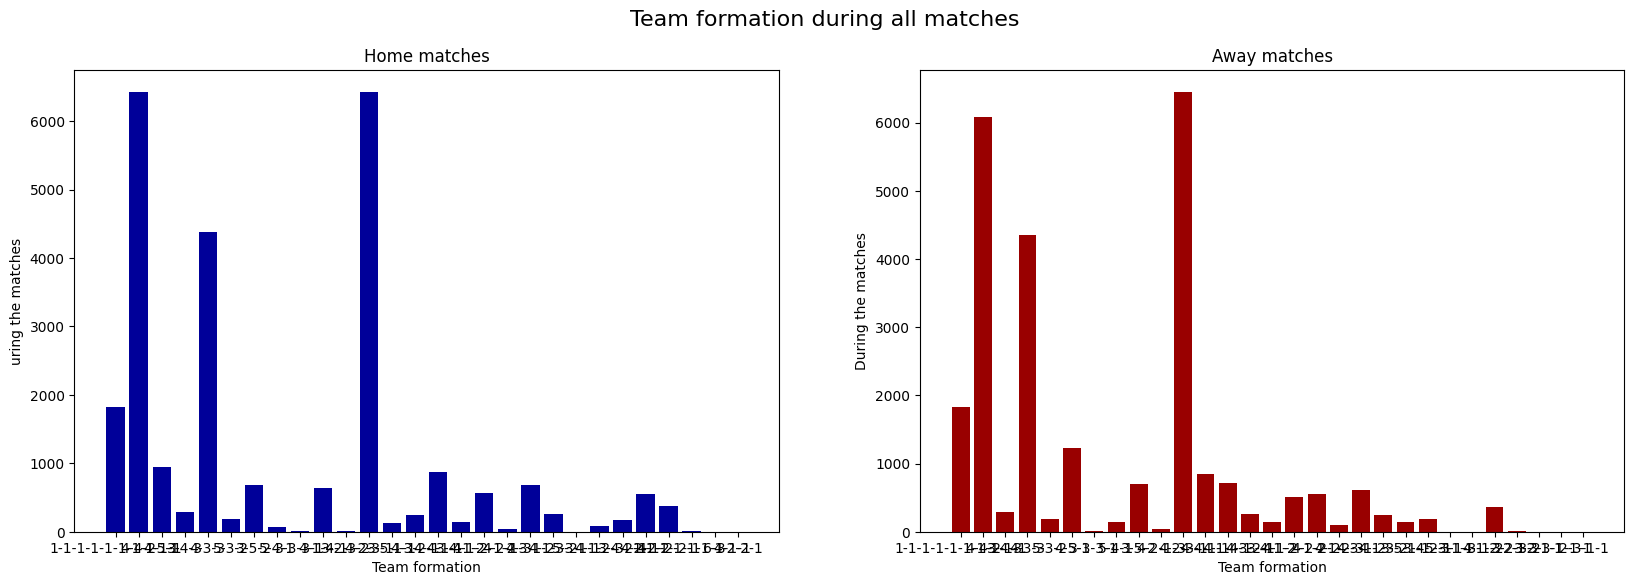

In [82]:
formation=team_formation(df_match)   
home_team_formation = formation[::2]
away_team_formation = formation[1::2]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,6))

ax1.bar(Counter(home_team_formation).keys(), Counter(home_team_formation).values(), color=(0,0,0.6))
ax2.bar(Counter(away_team_formation).keys(), Counter(away_team_formation).values(), color=(0.6,0,0))

ax1.set_ylabel('uring the matches')
ax1.set_xlabel('Team formation')
ax1.set_title('Home matches')

ax2.set_ylabel('During the matches')
ax2.set_xlabel('Team formation')
ax2.set_title('Away matches')

fig.suptitle('Team formation during all matches', fontsize=16)

plt.show()

In [83]:
# printing all the unique team formation in all the matcheds
print(len(list(set(home_team_formation))))
print(len(list(set(away_team_formation))))

28
29


In [80]:
# TODO: still need to add new team formation features to the main table

# reaming work

In [ ]:
# print(df_match.shape)
# print(df_match["goal"].isnull().sum(), end=" missing values\n")
# print(df_match["shoton"].isnull().sum(), end=" missing values\n")
# print(df_match["shotoff"].isnull().sum(), end=" missing values\n")
# print(df_match["foulcommit"].isnull().sum(), end=" missing values\n")
# print(df_match["card"].isnull().sum(), end=" missing values\n")
# print(df_match["cross"].isnull().sum(), end=" missing values\n")
# print(df_match["corner"].isnull().sum(), end=" missing values\n")
# print(df_match["possession"].isnull().sum(), end=" missing values\n")
# print(df_match["foulcommit"].isnull().sum(), end=" missing value\ns")
# print(df_match["B365H"].isnull().sum(), end=" missing values\n")
# print(df_match["B365D"].isnull().sum(), end=" missing values\n")
# print(df_match["B365A"].isnull().sum(), end=" missing values\n")
# print(df_match["BWH"].isnull().sum(), end=" missing values\n")
# print(df_match["BWD"].isnull().sum(), end=" missing values\n")
# print(df_match["BWA"].isnull().sum(), end=" missing values\n")
# print(df_match["IWH"].isnull().sum(), end=" missing values\n")
# print(df_match["IWD"].isnull().sum(), end=" missing values\n")
# print(df_match["LBH"].isnull().sum(), end=" missing values\n")
# print(df_match["IWD"].isnull().sum(), end=" missing values\n")
# print(df_match["LBH"].isnull().sum(), end=" missing values\n")
# print(df_match["LBD"].isnull().sum(), end=" missing values\n")
# print(df_match["LBA"].isnull().sum(), end=" missing values\n")
# print(df_match["PSH"].isnull().sum(), end=" missing values\n")
# print(df_match["PSD"].isnull().sum(), end=" missing values\n")
# print(df_match["PSA"].isnull().sum(), end=" missing values\n")
# print(df_match["WHH"].isnull().sum(), end=" missing values\n")
# print(df_match["WHD"].isnull().sum(), end=" missing values\n")
# print(df_match["WHA"].isnull().sum(), end=" missing values\n")
# print(df_match["SJH"].isnull().sum(), end=" missing values\n")
# print(df_match["SJD"].isnull().sum(), end=" missing values\n")
# print(df_match["SJA"].isnull().sum(), end=" missing values\n")
# print(df_match["VCH"].isnull().sum(), end=" missing values\n")
# print(df_match["VCD"].isnull().sum(), end=" missing values\n")
# print(df_match["VCA"].isnull().sum(), end=" missing values\n")
# print(df_match["GBH"].isnull().sum(), end=" missing values\n")
# print(df_match["GBD"].isnull().sum(), end=" missing values\n")
# print(df_match["GBA"].isnull().sum(), end=" missing values\n")
# print(df_match["BSH"].isnull().sum(), end=" missing values\n")
# print(df_match["BSD"].isnull().sum(), end=" missing values\n")
# print(df_match["BSA"].isnull().sum(), end=" missing values\n")

# Generating Target Variable

In [ ]:
# generating target variable
def get_match_label(match):
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']
    #Identify match label
    if home_goals > away_goals:
        return "HomeWin"
    elif home_goals == away_goals:
        return "Draw"
    elif home_goals < away_goals:
        return "AwayWin"

df_merged_all_table['target'] = df_merged_all_table.apply(get_match_label, axis=1)

In [ ]:
# droping columns with contains id (Converting n3 form to n1 form)
df_merged_all_table = df_merged_all_table.drop(['home_team_goal',
       'away_team_goal'], axis=1)

df_merged_all_table.columns

# Converting dataframe into pickle file for modeling

In [ ]:
# Converting dataframe into pickle for modeling

# df_merged_all_table.to_pickle('merged_all_table' + ".pkl", compression="bz2")
# df_merged_all_table.to_csv( 'merged_all_table.csv',index=False)